In [1]:
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential

: 

: 

In [4]:
df = pd.read_csv('codes.csv') # read in qr code data

In [5]:
# parse a column with a 2d array of each qr code and a one d array of each qr code
df['code_array'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x]).reshape(29, 29))
df['code_oned'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x]))

In [6]:
# takes in an array and L parameter and returns centered submatrix of length 2L+1
def get_centered_subarray(array, L):
    L = (L * 2) + 1 # length
    n = array.shape[0]
    center = n // 2
    start = center - (L // 2)
    end = center + (L + 1) // 2
    # Adjust indices to stay within array bounds (allows for wrapping)
    start = max(0, start)
    end = min(n, end)
    return array[start:end, start:end]

In [7]:
# Function to split DFT into real and imaginary parts and reshape them
def split_dft(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    imag_part = np.array([c.imag for c in complex_numbers])
    return real_part, imag_part

# Apply the function to each row
df['dft_real'], df['dft_imag'] = zip(*df['dft'].apply(split_dft))

In [18]:
# (deprecated function) zero pads from the right
def zero_pad_right(per, arr):
    index = int(per * len(arr))
    for i in range(index, len(arr)):
        arr[i] = 0
    return arr

In [14]:
# (deprecated function) parse dft's data to 1d array of length 29**2*2

def combine_dft_full(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    # real_part = zero_pad_right(0.5, real_part)
    imag_part = np.array([c.imag for c in complex_numbers])
    # imag_part = zero_pad_right(0.5, imag_part)
    return np.append(real_part, imag_part)

df['dft_stacked'] = df['dft'].apply(combine_dft_full)

In [15]:
df['dft_stacked'][0]

array([ 4.27000000e+02, -2.81751760e+00,  2.43744204e-01, ...,
       -5.08998548e+00,  1.27562664e+01,  8.68168459e+00])

In [23]:
# The X here is deprecated becasue we first need to transform into L matrix

# Features (X) - DFT components
# X = np.stack(df['dft_stacked'].values)  # Shape: (num_samples, 1682)

# Labels (y) - QR codes
y = np.stack(df['code_array'].values)  # Shape: (num_samples, 29,29)

# # Split the data into training and testing sets
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# X_tr, X_te = split_data(df[']dfts, 0.8, 12345)
# y_tr, y_te = split_data(codes, 0.8, 12345)

NameError: name 'dfts' is not defined

In [11]:
# (deprecated) overcomplicated model

import tensorflow as tf
from tensorflow.keras import layers, models

# Defining CNN model
multilayered_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(29, 29, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(29 * 29 * 64, activation='relu'),  # Adjusting to match the target shape
    layers.Reshape((29, 29, 64)),
    layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')  # Output should match the shape of QR code (29x29)
])

# Compile the model
multilayered_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
multilayered_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

In [9]:
# function to initialize model for a given L size input

def init_model(L):
    model = tf.keras.Sequential()
    
    # Add the input layer (implicitly defined by the first layer) size of the L matrix times 2 to include both real and imaginary components
    model.add(tf.keras.layers.InputLayer(input_shape=((((L*2)+1)**2)*2,)))
    
    # Add the output layer with Y units (no activation for regression, 'softmax' or 'sigmoid' for classification)
    model.add(tf.keras.layers.Dense(841))
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    # Compile the model (use appropriate loss and metrics for your task)
    model.compile(optimizer=optimizer, loss='mse')  # or 'categorical_crossentropy' for classification
    return model

In [31]:
# function to initialize model for a given L size input with convo layer

def init_model_convo(L):
    L = (((L*2)+1)**2)*2
    
    # Initialize the Sequential model
    model = tf.keras.Sequential()
    
    # Input layer: Accepts (L, L, 2) where L < 29
    model.add(tf.keras.layers.InputLayer(input_shape=(None, None, 2)))  # None allows for variable L
    
    # Convolutional Layer
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
    
    # Resizing Layer to upscale to 29x29
    model.add(tf.keras.layers.Resizing(height=29, width=29, interpolation='bilinear'))
    
    # Output Layer
    model.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same'))
    
    # Display the model summary
    model.summary()

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    # Compile the model
    model.compile(optimizer=optimizer, loss='mse')

    return model

In [32]:
# model = Sequential([Dense(29*29*2, input_dim=29*29*2, use_bias=False)])
# model.compile(loss='mean_squared_error', optimizer='adam', )

In [17]:
# flatten data (DEPRECATED)
for set in [X_train, X_test, y_train, y_test]:
    for i in range(len(set)):
        set[i] = set[i].flatten()

ValueError: could not broadcast input array from shape (1682,) into shape (29,29,2)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, num_samples=5):
    """
    Evaluates the trained model on the test set and displays a few samples with their predictions.

    Parameters:
    - model: The trained TensorFlow/Keras model.
    - X_test: The input features for the test set (shape: (num_samples, 1682)).
    - y_test: The true labels for the test set (shape: (num_samples, 841)).
    - num_samples: The number of test samples to display.

    Returns:
    - accuracy: The overall accuracy of the model on the test set.
    """
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Binarize the predictions (0 or 1)
    predictions_binarized = (predictions > 0.5).astype(np.int32)
    
    # Calculate accuracy
    correct_predictions = np.sum(predictions_binarized == y_test)
    total_elements = y_test.size
    accuracy = correct_predictions / total_elements
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Display some predictions
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        # Original QR code
        plt.subplot(1, 3, 1)
        plt.title("Original QR Code")
        plt.imshow(y_test[i].reshape(29, 29), cmap='gray')
        plt.axis('off')

        # Predicted QR code
        plt.subplot(1, 3, 2)
        plt.title("Predicted QR Code")
        plt.imshow(predictions_binarized[i].reshape(29, 29), cmap='gray')
        plt.axis('off')

        # Difference (Error)
        plt.subplot(1, 3, 3)
        plt.title("Difference (Error)")
        plt.imshow(y_test[i].reshape(29, 29) - predictions_binarized[i].reshape(29, 29), cmap='gray')
        plt.axis('off')

        plt.show()
        
    return accuracy

# Example usage:
accuracy = evaluate_model(model, X_test[:999], y_test[:999], num_samples=5)


NameError: name 'model' is not defined

In [12]:
def combine_dft(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    real_part = zero_pad_right(per, real_part)
    imag_part = np.array([c.imag for c in complex_numbers])
    imag_part = zero_pad_right(per, imag_part)
    return np.append(real_part, imag_part)



In [13]:
# take in full size 1d array,reshape it to original 29 by 29, and shift it so center is in right place
df['dft_imag_rolled'] = df['dft_imag'].apply(lambda x: np.roll(x.reshape(29,29), shift=(14, 14), axis=(0, 1)))
df['dft_real_rolled'] = df['dft_real'].apply(lambda x: np.roll(x.reshape(29,29), shift=(14, 14), axis=(0, 1)))

In [14]:
df['dft_imag_rolled'][0].shape

(29, 29)

In [15]:
# (depreacted loop from 10/2/24) loop to train model for different L sizes. use other loop for convo.

# stat stores L size with accuracy for plotting after
# stat = []
# for L in range(10,0,-1):
#     # get L matrices flattened
#     df['L_imag'] = df['dft_imag_rolled'].apply(lambda x: get_centered_subarray(x, L).flatten())
#     df['L_real']= df['dft_imag_rolled'].apply(lambda x: get_centered_subarray(x, L).flatten())
#     # diagnostic print
#     print(df['L_imag'][0].shape)
#     # concatenate imag and real 1d arrays
#     df['L'] = df.apply(lambda row: np.concatenate((row['L_real'], row['L_imag'])), axis=1)
#     model = init_model_convo(L)
#     # Features (X) - DFT components
#     X = np.stack(df['L'].values)  # Shape: (num_samples, ((L*2)+1)*2)
#     print(X.shape)
#     # Split the data into training and testing sets
#     # y sets should be initialized outside loop since they don't change
#     from sklearn.model_selection import train_test_split
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Fit the model
#     model.fit(X_train, y_train, epochs=100, validation_data=[X_test[1000:], y_test[1000:]])

#     # eval model
#     accuracy = evaluate_model(model, X_test[:999], y_test[:999], num_samples=1)
#     stat.append((L, accuracy))

# print(stat)

(441,)


NameError: name 'InputLayer' is not defined

In [ ]:
# loop to TRAIN model over different L values (use other loop for CNN)
from sklearn.model_selection import train_test_split
# stat stores L size with accuracy for plotting after
stat = []
for L in range(10,0,-1): # iterate through 10 - 1
    # get L matrices flattened
    df['L_imag'] = df['dft_imag_rolled'].apply(lambda x: get_centered_subarray(x, L).flatten())
    df['L_real']= df['dft_imag_rolled'].apply(lambda x: get_centered_subarray(x, L).flatten())
    # diagnostic print
    print(df['L_imag'][0].shape)
    # concatenate imag and real 1d arrays
    df['L'] = df.apply(lambda row: np.concatenate((row['L_real'], row['L_imag'])), axis=1)
    model = init_model(L)
    # Features (X) - DFT components
    X = np.stack(df['L'].values)  # Shape: (num_samples, ((L*2)+1)*2)
    print(X.shape)
    # Split the data into training and testing sets
    # y sets should be initialized outside loop since they don't change
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model.fit(X_train, y_train, epochs=100, validation_data=[X_test[1000:], y_test[1000:]])

    # eval model
    accuracy = evaluate_model(model, X_test[:999], y_test[:999], num_samples=1)
    stat.append((L, accuracy))

print(stat)

In [18]:
# Define a function to combine real and imaginary parts
def combine_real_imag(row):
    # Stack along the last axis to create a new dimension for channels
    combined = np.stack((row['L_real'], row['L_imag']), axis=-1)
    return combined  # Shape: (L, L, 2)



In [25]:
def evaluate_model(model, X, y, num_samples=999):
    """
    Evaluate the model's pixel-wise accuracy on a subset of the test data.
    
    Parameters:
    - model: Trained Keras model.
    - X: Test input data, shape (num_samples_total, L, L, 2).
    - y: True QR codes, shape (num_samples_total, 29, 29, 1).
    - num_samples: Number of samples to evaluate.
    
    Returns:
    - average_accuracy: Average pixel-wise accuracy over the selected samples.
    """
    # Ensure num_samples does not exceed the available samples
    num_samples = min(num_samples, X.shape[0])
    
    # Predict the QR codes
    y_pred = model.predict(X[:num_samples])
    
    # Check if the shapes match
    if y_pred.shape != y[:num_samples].shape:
        # If y_pred is (num_samples, 29, 29, 1) and y is (num_samples, 29, 29, 1), it's okay
        # Otherwise, attempt to reshape if possible
        try:
            y_pred = y_pred.reshape(y[:num_samples].shape)
        except:
            raise ValueError(f"Shape mismatch: y_pred shape {y_pred.shape} vs y shape {y[:num_samples].shape}")
    
    # Apply a threshold to convert predictions to binary
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Calculate pixel-wise accuracy
    correct_pixels = (y_pred_binary == y[:num_samples]).astype(int)
    pixel_accuracy = correct_pixels.mean()
    
    # maybe try removing fixed structure to show message encoded pixels accuracy?
    
    return pixel_accuracy


In [32]:
# loop to train model for different L sizes. use this loop for CNN (?)
from sklearn.model_selection import train_test_split

# stat stores L size with accuracy for plotting after
stat = []
for L in [10, 9, 8]:
    # get L matrices flattened
    df['L_imag'] = df['dft_imag_rolled'].apply(lambda x: get_centered_subarray(x, L))
    df['L_real']= df['dft_real_rolled'].apply(lambda x: get_centered_subarray(x, L))

    # Apply the function to each row to create the 'L_combined' column
    df['L'] = df.apply(combine_real_imag, axis=1)
    # diagnostic print
    print(df['L'][0].shape)
    # concatenate imag and real 1d arrays
    model = init_model_convo(L)
    # Features (X) - DFT components
    X = np.stack(df['L'].values)  
    print(X.shape)
    # Split the data into training and testing sets

    # y sets should be initialized outside loop since they don't change
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model.fit(X_train, y_train, epochs=50, validation_data=[X_test[1000:], y_test[1000:]]) # currently only doing 50 epochs for 3 values of L
    # we should try 100-150 epochs for one value of L to start (maybe starting at 12?)

    # eval model
    accuracy = evaluate_model(model, X_test[:999], y_test[:999], num_samples=1)
    
    stat.append((L, accuracy)) # L parameter used and accuracy achieved

    print(stat)

(21, 21, 2)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, None, None, 16)    304       
                                                                 
 resizing_10 (Resizing)      (None, 29, 29, 16)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 29, 29, 1)         145       
                                                                 
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
(9999, 21, 21, 2)
Epoch 1/50
250/250 [==============================] - 3s 12ms/step - loss: 0.3516 - val_loss: 0.3102
Epoch 2/50
250/250 [==============================] - 3s 12ms/step - loss: 0.2938 - val_loss: 0.2823
Epoch 3/50
250/250 [==============================] - 3s 12ms/step - loss: 0.2750 - val

In [27]:
stat

[(10, 0.5481569560047562)]

In [74]:
rstat = stat[::-1]
rstat

[(0, 0.4927174499112668),
 (0.05, 0.7652337236166011),
 (0.1, 0.7877592217663562),
 (0.15, 0.8040549467422238),
 (0.2, 0.822725222249598),
 (0.25, 0.8430439952437574),
 (0.3, 0.87219800061655),
 (0.35, 0.8962351174003969),
 (0.4, 0.9238846456444554),
 (0.45, 0.954785939328151),
 (0.5, 0.9956436817316722)]

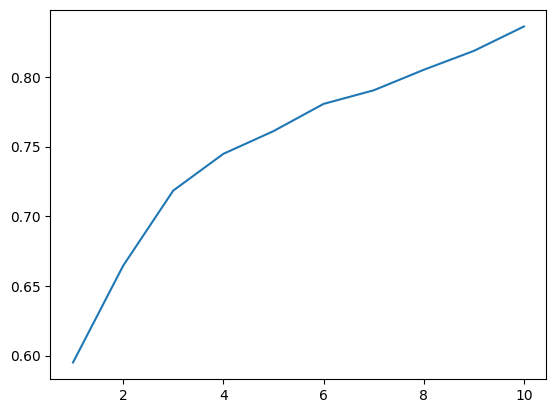

In [40]:
plt.plot([st[0] for st in stat], [st[1] for st in stat]) # plot of L vs accuracy